In [1]:
import os
import glob
import json
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [23]:
from llava.constants import IMAGE_TOKEN_INDEX
from llava.model.builder import load_pretrained_model
from llava.mm_utils import get_model_name_from_path, tokenizer_image_token

model_base = None  # "/home/chengzhang/models/llava/llava-v1-0719-336px-lora-merge-vicuna-13b-v1.3"
model_path = "/home/chengzhang/models/llava/llava-v1.5-7b"  # "/home/chengzhang/models/llava/llava-336px-pretrain-vicuna-13b-v1.3"
model_name = get_model_name_from_path(model_path)
tokenizer, model, image_processor, context_len = load_pretrained_model(
    model_path, model_base, model_name
)

/home/chengzhang/anaconda3/envs/minigpt4/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


[2023-11-08 02:57:18,061] [INFO] [real_accelerator.py:110:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [20]:
def act(x: torch.Tensor):
    return torch.nn.functional.silu(x)

In [9]:
def load_tensor(
    layer: int,
    comp: str,
    stage: str,
) -> np.ndarray:
    folder = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot/tmp'
    act: torch.Tensor = torch.load(f'{folder}/model.layers.{layer}.{comp}-{stage}.pt')
    return act

def plot_quant(ax: plt.Axes, before: np.ndarray, after: np.ndarray, bins: int = 200):
    freqs_before, _, _ = ax.hist(before, bins=bins)
    freqs_after, _, _ = ax.hist(after, bins=bins)

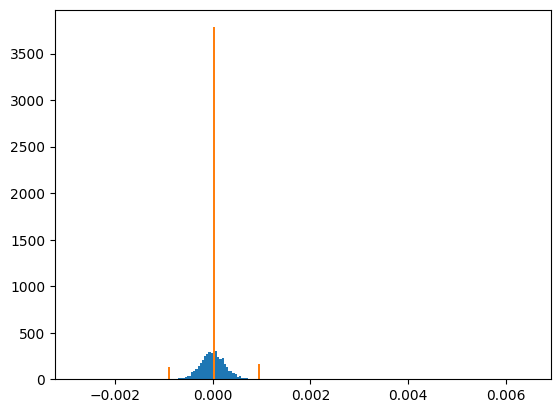

In [18]:
x1 = load_tensor(0, 'mlp.up_proj', 'before')[0, 4, :].flatten().cpu().numpy()
x2 = load_tensor(0, 'mlp.up_proj', 'after')[0, 4, :].flatten().cpu().numpy()
ax = plt.subplot(1, 1, 1)
plot_quant(ax, x1, x2)

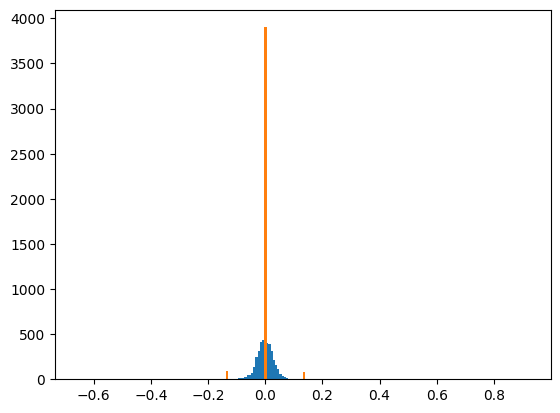

In [19]:
x1 = load_tensor(0, 'mlp.up_proj', 'before')[0, -1, :].flatten().cpu().numpy()
x2 = load_tensor(0, 'mlp.up_proj', 'after')[0, -1, :].flatten().cpu().numpy()
ax = plt.subplot(1, 1, 1)
plot_quant(ax, x1, x2)

In [21]:
x1

array([ 0.003025 , -0.01953  , -0.0421   , ...,  0.02731  , -0.0003629,
       -0.01226  ], dtype=float16)

In [22]:
x2

array([ 0., -0., -0., ...,  0., -0., -0.], dtype=float16)

In [24]:
mlp = model.model.layers[0].mlp

In [25]:
x_before = load_tensor(0, 'mlp.up_proj', 'before')
x_after = load_tensor(0, 'mlp.up_proj', 'after')

In [26]:
mlp.down_proj(act(mlp.gate_proj(x_before)) * mlp.up_proj(x_before))

tensor([[[-8.9407e-07,  5.9605e-08, -5.3644e-07,  ...,  1.7881e-07,
           5.9605e-08,  1.7881e-07],
         [-8.9407e-07,  5.9605e-08, -5.3644e-07,  ...,  1.7881e-07,
           5.9605e-08,  1.7881e-07],
         [-8.9407e-07,  5.9605e-08, -5.3644e-07,  ...,  1.7881e-07,
           5.9605e-08,  1.7881e-07],
         ...,
         [ 1.6861e-02,  2.5955e-02, -1.4778e-02,  ...,  5.9509e-03,
          -1.4549e-02,  3.4313e-03],
         [ 2.7790e-03,  1.7843e-03,  3.0732e-04,  ..., -1.0902e-02,
          -5.9547e-03, -5.7335e-03],
         [ 1.5039e-03, -7.4272e-03,  3.5667e-03,  ...,  1.8930e-03,
          -5.2109e-03, -7.3471e-03]],

        [[-8.9407e-07,  5.9605e-08, -5.3644e-07,  ...,  1.7881e-07,
           5.9605e-08,  1.7881e-07],
         [-8.9407e-07,  5.9605e-08, -5.3644e-07,  ...,  1.7881e-07,
           5.9605e-08,  1.7881e-07],
         [-8.9407e-07,  5.9605e-08, -5.3644e-07,  ...,  1.7881e-07,
           5.9605e-08,  1.7881e-07],
         ...,
         [ 1.6861e-02,  2

In [27]:
mlp.down_proj(act(mlp.gate_proj(x_after)) * mlp.up_proj(x_after))

tensor([[[-4.1723e-07,  5.9605e-08, -4.7684e-07,  ...,  2.9802e-07,
           0.0000e+00, -0.0000e+00],
         [-4.1723e-07,  5.9605e-08, -4.7684e-07,  ...,  2.9802e-07,
           0.0000e+00, -0.0000e+00],
         [-4.1723e-07,  5.9605e-08, -4.7684e-07,  ...,  2.9802e-07,
           0.0000e+00, -0.0000e+00],
         ...,
         [ 1.7792e-02,  2.2324e-02, -1.5854e-02,  ...,  4.6196e-03,
          -9.9411e-03,  1.4257e-03],
         [-2.2316e-03, -1.2007e-03, -2.2399e-04,  ..., -6.1646e-03,
          -6.0272e-03, -1.1075e-04],
         [ 2.0638e-03, -7.9880e-03,  1.6165e-03,  ..., -9.2220e-04,
          -3.9940e-03, -5.7831e-03]],

        [[-4.1723e-07,  5.9605e-08, -4.7684e-07,  ...,  2.9802e-07,
           0.0000e+00, -0.0000e+00],
         [-4.1723e-07,  5.9605e-08, -4.7684e-07,  ...,  2.9802e-07,
           0.0000e+00, -0.0000e+00],
         [-4.1723e-07,  5.9605e-08, -4.7684e-07,  ...,  2.9802e-07,
           0.0000e+00, -0.0000e+00],
         ...,
         [ 1.7792e-02,  2

In [30]:
y_before = load_tensor(0, 'mlp.down_proj', 'before')
y_after = load_tensor(0, 'mlp.down_proj', 'after')

In [47]:
def quant_activation_round_to_nearest(x: torch.Tensor, bits: int, dim: int = 1):
    act_scales = torch.max(torch.abs(x), dim=dim, keepdim=True).values.to(torch.float32)
    s = (2 ** (bits - 1) - 1) / (act_scales + 1e-6)
    x = torch.round(x * s).div(s).to(torch.float16)
    return x

In [48]:
quant_activation_round_to_nearest(y_before, bits=4, dim=-1)

tensor([[[0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., 0., -0.],
         ...,
         [-0., 0., -0.,  ..., -0., 0., 0.],
         [0., -0., 0.,  ..., 0., -0., -0.],
         [-0., 0., 0.,  ..., -0., -0., -0.]],

        [[0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., 0., -0.],
         ...,
         [-0., 0., -0.,  ..., -0., 0., 0.],
         [0., -0., 0.,  ..., 0., -0., -0.],
         [-0., 0., 0.,  ..., -0., -0., -0.]],

        [[0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., 0., -0.],
         ...,
         [-0., 0., -0.,  ..., -0., 0., 0.],
         [0., -0., 0.,  ..., 0., -0., -0.],
         [-0., 0., 0.,  ..., -0., -0., -0.]],

        ...,

        [[0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., 0., -0.],
         [0., -0., 0.,  ..., 0., -0., 0.],
         ...,
         

In [2]:
def f(x):
    y = 0.5 * x ** 3 + 0.5 * x
    return y

def g(x):
    y = 0.693361 / np.power(1.73205 * np.sqrt(27 * np.square(x) + 1) - 9 * x, 1 / 3) - \
        0.48075 * np.power(1.73205 * np.sqrt(27 * np.square(x) + 1) - 9 * x, 1 / 3)
    return y

In [87]:
def symmetric_cbrt(x: torch.Tensor, bits: int, dim: int = 1):
    act_scales = torch.max(torch.abs(x), dim=dim, keepdim=True).values
    x /= act_scales
    x = 0.693361 / torch.pow(1.73205 * torch.sqrt(27 * torch.square(x) + 1) - 9 * x, 1 / 3) - \
        0.48075 * torch.pow(1.73205 * torch.sqrt(27 * torch.square(x) + 1) - 9 * x, 1 / 3)
    bins = 2 ** (bits - 1)
    x = torch.round(x * bins) / bins
    x = (0.5 * torch.pow(x, 3) + 0.5 * x) * act_scales
    return x.where(torch.isfinite(x), 0.0)

def symmetric_sqrt(x: torch.Tensor, bits: int, dim: int = 1):
    act_scales = torch.max(torch.abs(x), dim=dim, keepdim=True).values
    x = torch.sign(x) * torch.sqrt(torch.abs(x) / act_scales)
    bins = 2 ** (bits - 1)
    x = torch.round(x * bins) / bins
    x = torch.sign(x) * torch.square(x) * act_scales
    return x.where(torch.isfinite(x), 0.0)

def quant_activations(x: torch.Tensor, bits: int = 4, dim: int = 1, outliers_thres: float = 3.0):
    x = x.to(torch.float64)
    if outliers_thres > 0:
        raw_x = x.clone()
        # act_means = torch.mean(x, dim=dim, keepdim=True)
        # act_stds = torch.std(x, dim=dim, keepdim=True)
        # print(act_means)
        # print(act_stds)
        lower_bound = torch.quantile(x, 0.025, dim=dim, keepdim=True)
        upper_bound = torch.quantile(x, 0.975, dim=dim, keepdim=True)
        quant_mask = torch.bitwise_and(
            raw_x > lower_bound,  # act_means - outliers_thres * act_stds,
            raw_x < upper_bound,  # act_means + outliers_thres * act_stds,
        )
        x = x.where(quant_mask, 0.0)
    x = symmetric_cbrt(x, bits, dim)
    if outliers_thres > 0:
        x = x.where(quant_mask, raw_x)
    x = x.to(torch.float16)
    return x

torch.Size([23])


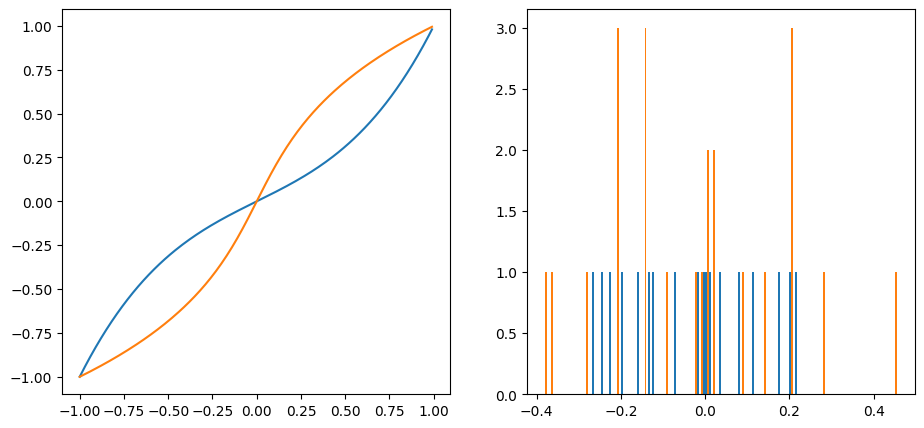

In [29]:
arange = np.arange(-1, 1, 0.01)
# data = np.random.normal(loc=0.0, scale=0.5, size=10000)

folder = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot/activations'
act: torch.Tensor = torch.load(f'{folder}/949225/llama/15-up-proj.pt')[0]
x = act[0, 4:580, 31].detach().cpu()
print(x.shape)

bits = 4
# bins = 2 ** (bits - 1)
# ticks = f(np.arange(-1, 1.01, 1 / bins))
# x = torch.tensor(data, dtype=torch.float16)
y = quant_activations(x, bits, 0, outliers_thres=2)

plt.figure(figsize=(11, 5))

ax = plt.subplot(1, 2, 1)
ax.plot(arange, f(arange))
ax.plot(arange, g(arange))

ax = plt.subplot(1, 2, 2)
# for pos in ticks:
#     ax.plot([pos, pos], [0, np.max(freqs)], color='C1', linewidth=1)
freqs, _, _ = plt.hist(x, bins=180)
freqs, _, _ = plt.hist(y, bins=180)

In [2]:
def linear_k_means(data: np.ndarray, bins: int, iters: int = 100):
    min_val = np.min(data)
    max_val = np.max(data)
    # init_bounds = np.arange(0, 1.01, 1 / bins) * (max_val - min_val) + min_val
    # pivots = (np.arange(bins) + 0.5) / bins * (max_val - min_val) + min_val
    pivots = np.random.uniform(min_val, max_val, size=bins)
    while len(set(np.argmin(np.square(data[:, None] - pivots[None, :]), axis=-1))) < bins:
        pivots = np.random.uniform(min_val, max_val, size=bins)
    # print(pivots)
    for i in range(iters):
        quants = np.argmin(np.square(data[:, None] - pivots[None, :]), axis=-1)
        print(f'[#{i}] {np.sum(np.square(pivots[quants] - data))}')
        tmp_pivots = np.array([data[quants == x].mean() for x in range(bins)])
        pivots = np.where(np.isfinite(tmp_pivots), tmp_pivots, pivots)
    return pivots

np.random.seed(42)
# data = np.random.normal(0, 1, size=(65536, ))

folder = '/home/chengzhang/Multimodal-Quantization/LLaVA/snapshot/activations'
paths = glob.glob(f'{folder}/*/llama/14-down-proj.pt')
act = torch.concat([torch.load(path)[0][:, 4:580, 31].detach().flatten() for path in paths])
data = act.cpu().numpy()

pivots = linear_k_means(data, bins=16)

[#0] 0.37477985395694224
[#1] 0.26735459400820005
[#2] 0.23158518380134652
[#3] 0.20704581297374958
[#4] 0.1925433660523801
[#5] 0.18261390999791516
[#6] 0.17448249500305124
[#7] 0.16657542545536685
[#8] 0.15846573683791476
[#9] 0.15046068711334115
[#10] 0.14306190455713264
[#11] 0.13687721701908018
[#12] 0.13182841991838146
[#13] 0.12769652315964564
[#14] 0.1245239687894788
[#15] 0.12250265069903676
[#16] 0.12127647140934883
[#17] 0.12052342808576455
[#18] 0.11969461071291576
[#19] 0.11882214198292118
[#20] 0.1180031042360703
[#21] 0.11705527331580257
[#22] 0.11601497393369087
[#23] 0.1146876570666997
[#24] 0.1129005192467254
[#25] 0.11099199181782993
[#26] 0.10964010713766825
[#27] 0.10846401038449827
[#28] 0.10755967553788892
[#29] 0.10675556168493827
[#30] 0.10586092430171234
[#31] 0.10483912611332258
[#32] 0.10377672621016032
[#33] 0.1026137640416529
[#34] 0.1014143568949386
[#35] 0.10061186527505939
[#36] 0.09986630038440936
[#37] 0.09904219763211941
[#38] 0.09802972673620403
[#3

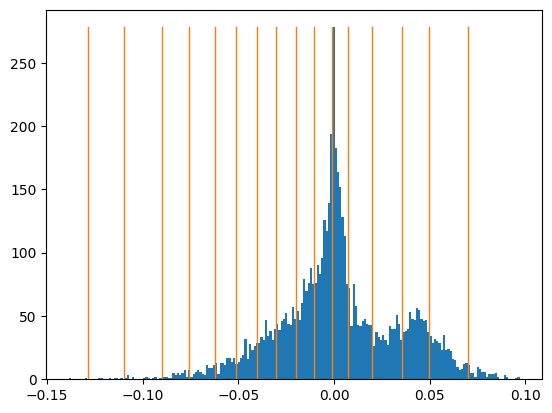

In [99]:
freqs, _, _ = plt.hist(data, bins=200)
for pos in pivots:
    plt.plot([pos, pos], [0, np.max(freqs)], color='C1', linewidth=1)
# for pos in pivots:
#     plt.plot([pos, pos], [0, np.max(freqs)], color='C2', linewidth=1)

0.0707


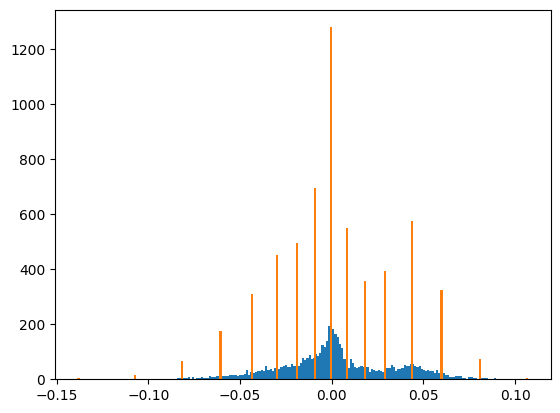

In [102]:
quanted = quant_activations(torch.tensor(data), 4, 0, outliers_thres=-1).cpu().numpy()
freqs, _, _ = plt.hist(data, bins=200)
freqs, _, _ = plt.hist(quanted, bins=200)
print(np.sum(np.square(data - quanted)))

0.03824


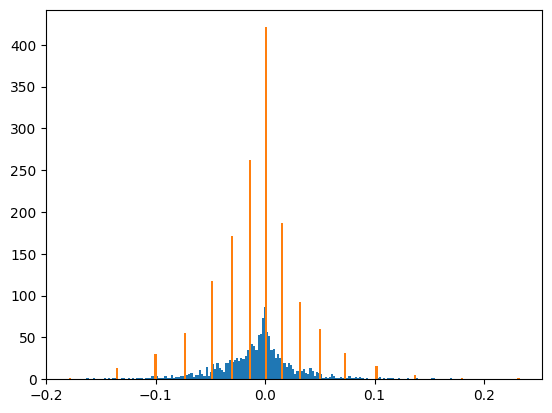

In [88]:
quanted = quant_activations(torch.tensor(data), 4, 0, outliers_thres=-1).cpu().numpy()
freqs, _, _ = plt.hist(data, bins=200)
freqs, _, _ = plt.hist(quanted, bins=200)
print(np.sum(np.square(data - quanted)))

In [ ]:
quanted = quant_activations(torch.tensor(data), 4, 0, outliers_thres=-1).cpu().numpy()
freqs, _, _ = plt.hist(data, bins=200)
freqs, _, _ = plt.hist(quanted, bins=200)
print(np.sum(np.square(data - quanted)))

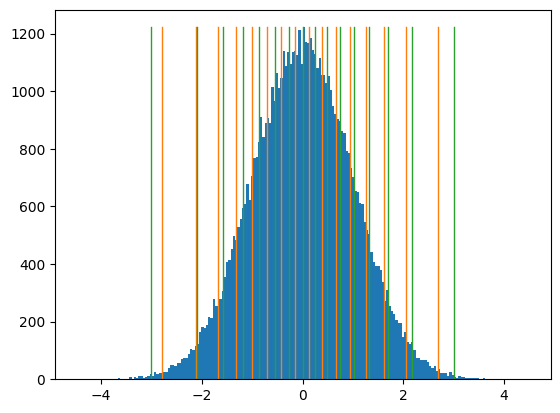

In [66]:
NF4_DATA = [
    -1.0,
    -0.6961928009986877,
    -0.5250730514526367,
    -0.39491748809814453,
    -0.28444138169288635,
    -0.18477343022823334,
    -0.09105003625154495,
    0.0,
    0.07958029955625534,
    0.16093020141124725,
    0.24611230194568634,
    0.33791524171829224,
    0.44070982933044434,
    0.5626170039176941,
    0.7229568362236023,
    1.0,
]
freqs, _, _ = plt.hist(data, bins=200)
for pos in pivots:
    plt.plot([pos, pos], [0, np.max(freqs)], color='C1', linewidth=1)
for pos in np.array(NF4_DATA) * 3:
    plt.plot([pos, pos], [0, np.max(freqs)], color='C2', linewidth=1)

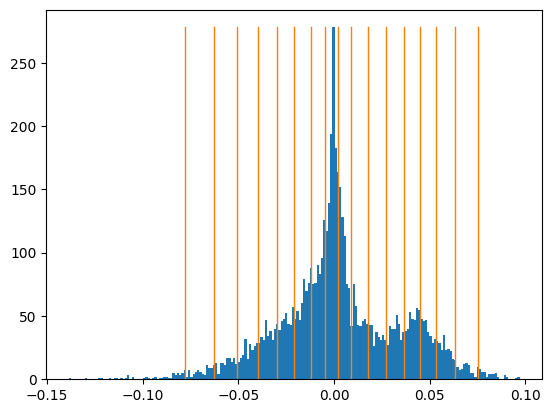

In [6]:
bins = 16
min_val = np.min(data)
max_val = np.max(data)
# init_bounds = np.arange(0, 1.01, 1 / bins) * (max_val - min_val) + min_val
# pivots = (np.arange(bins) + 0.5) / bins * (max_val - min_val) + min_val
freqs, _, _ = plt.hist(data, bins=200)
# for pos in pivots:
#     plt.plot([pos, pos], [0, np.max(freqs)], color='C1', linewidth=1)

new_pivots = [
    # -0.0740, -0.0560, -0.0446, -0.0367, -0.0288, -0.0210, -0.0137, -0.0072,
    # -0.0015,  0.0047,  0.0133,  0.0238,  0.0347,  0.0437,  0.0516,  0.0602,  0.0747,
    -0.0779, -0.0627, -0.0507, -0.0398, -0.0300, -0.0208, -0.0122, -0.0046,
    0.0020,  0.0090,  0.0177,  0.0272,  0.0366,  0.0450,  0.0532,  0.0631,  0.0750
]
for pos in new_pivots:
    plt.plot([pos, pos], [0, np.max(freqs)], color='C1', linewidth=1)